In [1]:
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['OMP_NUM_THREADS'] = '4'

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=3, rc={"lines.linewidth": 2})
sns.set_palette("Set1")

from tqdm import tqdm
import numpy as np
import jax
import jax.numpy as jnp
from flax.training import train_state
import optax

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "png")

/tmp/ipykernel_118601/3119869688.py:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "png")


In [3]:
from flax import linen as nn
from typing import Callable, List

def count_params(model, x):
    params = model.init(jax.random.PRNGKey(0), x)
    n = sum([np.prod(p.shape) for p in jax.tree_util.tree_leaves(params)])
    print(f'Number of parameters: {n/1e3} k')
    
def param_size(params):
    return sum([np.prod(p.shape) for p in jax.tree_util.tree_leaves(params)])

class NonLinearMixture(nn.Module):
    feature_fn: Callable
    act_fn: Callable
    prior_stds: List[float]
    is_orthogonal: bool = False

    @nn.compact
    def __call__(self, x):
        # evaluate basis functions
        features = self.feature_fn(x) # (n, d)
        # sample from N(0, prior_stds ** 2)
        mixture_coeffs = self.param('mixture_coeffs', lambda key: jax.random.normal(key, (features.shape[-1],)) * self.prior_stds)
        mixture_coeffs = self.act_fn(mixture_coeffs) / jnp.sqrt(mixture_coeffs.shape[-1]) # (d, )
        return (features @ mixture_coeffs).reshape(-1, 1) # (n, 1)
    
class LogDet:
    def __init__(self, model: NonLinearMixture, x_eval: jnp.ndarray, svd=False):
        features = model.feature_fn(x_eval) # (n, d)
        self.Phi = features.T @ features / features.shape[0] # (d, d)
        self.act_deriv = jax.grad(model.act_fn)
        self.act_deriv = jax.vmap(self.act_deriv)
        self.diag = model.is_orthogonal
        self.svd = svd
        
    
    def compute_log_det(self, model_params, jitter=0, return_J=False):
        # J[i,j] = s(w_i) * s(w_j) * Phi[i,j], where s is the derivative of model.act_fn
        s = self.act_deriv(model_params['params']['mixture_coeffs'])
        if self.diag:
            print('DIAG!')
            Phi_diag = jnp.diag(self.Phi)
            return jnp.sum(jnp.log(Phi_diag * (s ** 2) + jitter))
        J = s[:, None] * s[None, :] * self.Phi # (d, d)
        # compute with svd
        if self.svd:
            singular_values = jnp.linalg.svd(J, compute_uv=False)
            eigs = singular_values ** 2 + jitter
            logdet = jnp.sum(jnp.log(eigs))
        else:
            logdet = jnp.linalg.slogdet(J + jitter * jnp.eye(J.shape[0]))[1]
        if return_J:
            return logdet, J
        return logdet

In [4]:
def tree_norm(tree):
    return jnp.sqrt(sum([jnp.sum(x**2) for x in jax.tree_leaves(tree)]))

def random_split_like_tree(rng_key, target=None, treedef=None):
    if treedef is None:
        treedef = jax.tree_structure(target)
    keys = jax.random.split(rng_key, treedef.num_leaves)
    return jax.tree_unflatten(treedef, keys)

@jax.jit
def tree_random_normal_like(rng_key, target):
    keys_tree = random_split_like_tree(rng_key, target)
    return jax.tree_map(
        lambda l, k: jax.random.normal(k, l.shape, l.dtype),
        target,
        keys_tree,
    )

In [5]:
def optimize(train_loss_fn, test_loss_fn, neg_log_p_w_fn, n_train, init_params, lr, n_step, rng_key, model, x_eval_generator, logdet_calculator, optimizer, jitter, method, temp=1.0):    
    def get_train_state(optimizer, lr, init_params, warmup_steps=100):
        lr_sched = optax.linear_schedule(0, lr, warmup_steps, transition_begin=0)
        if optimizer == 'adam':
            tx = optax.chain(
                    optax.adam(learning_rate=lr_sched),
                )
        elif optimizer == 'sgd':
            tx = optax.sgd(learning_rate=lr_sched, momentum=0.9)
        else:
            raise NotImplementedError
        return train_state.TrainState.create(apply_fn=model.apply, params=init_params, tx=tx)
    
    ts = get_train_state(optimizer, lr, init_params)
    
    def augmented_loss_fn(p, x_eval, dp):
        # loss = likelihood / n_train = 1 / (2 * sigma^2) * ||y - f(x)||^2 / n_train
        # it contains a factor 1 / n_train
        # all other terms should be divided by n_train as well
        avg_nll = train_loss_fn(p) 
        test_loss = test_loss_fn(p)
        # number of params
        P = jax.tree_util.tree_leaves(p)[0].shape[0]
        if method == 'fsmap':
            # logdet = 1 / 2 * log_det_g_svd(model, p, x_eval, jitter) / n_train
            logdet = 1 / 2 * logdet_calculator.compute_log_det(p, jitter) / n_train
        elif method == 'psmap':
            # logdet = 1 / 2 * log_det_g_svd(model, p, x_eval, jitter) / n_train
            logdet = 1 / 2 * logdet_calculator.compute_log_det(p, jitter) / n_train
            logdet = jax.lax.stop_gradient(logdet)
        else:
            raise NotImplementedError
        neg_log_p_w = neg_log_p_w_fn(p) / n_train #jnp.sum((params_flat ** 2) / (2 * (prior_stds ** 2))) / n_train
        logdet =  temp * logdet + (1 - temp) * jax.lax.stop_gradient(logdet)
        # return avg_nll + neg_log_p_w + logdet, (avg_nll, logdet, test_loss)
        return avg_nll + neg_log_p_w + logdet, (avg_nll, logdet, test_loss)

    grad_fn = jax.jit(jax.value_and_grad(lambda p, x_eval, dp: augmented_loss_fn(p, x_eval, dp), has_aux=True))
    losses = []
    logdets = []
    avg_nlls = []
    test_losss = []
    def sample_dp(p, rng_key):
        # gaussian tree
        dp = tree_random_normal_like(rng_key, p)
        return dp
    @jax.jit
    def train_step(ts, rng_key):
        rng_key, x_eval_key = jax.random.split(rng_key)
        rng_key, dp_key = jax.random.split(rng_key)
        x_eval = x_eval_generator(x_eval_key)
        dp = sample_dp(ts.params, dp_key)
        (loss, aux), grads = grad_fn(ts.params, x_eval, dp)
        ts = ts.apply_gradients(grads=grads)
        return ts, loss, aux, rng_key
    for _ in tqdm(range(int(n_step))):
        ts, loss, aux, rng_key = train_step(ts, rng_key)
        avg_nll, logdet, test_loss = aux
        losses.append(loss.item())
        logdets.append(logdet.item())
        avg_nlls.append(avg_nll.item())
        test_losss.append(test_loss.item())
    losses = np.array(losses)
    logdets = np.array(logdets)
    avg_nlls = np.array(avg_nlls)
    test_losss = np.array(test_losss)
    return ts.params, losses, avg_nlls, logdets, test_losss

In [7]:
def perturb(fn, p, noise_std=0.1, samples=10):
    # fn: parameters pytree -> number
    # p: parameters
    # noise: add noise N(0, noise_std^2) to the parameters
    # return average absolute change in fn if we perturb parameters
    changes = []
    fn0 = fn(p)
    for i in range(samples):
        rng_key = jax.random.PRNGKey(i)
        rng_key, rng_key_sample = jax.random.split(rng_key)
        dp = tree_random_normal_like(rng_key_sample, p)
        new_p = jax.tree_util.tree_map(lambda x, y: x + y * noise_std, p, dp)
        change = jnp.abs(fn(new_p) - fn0)
        changes.append(change)
    return jnp.array(changes).mean().item()


def avg_hess_eig(loss_fn, p):
    # fn: parameters pytree -> number
    # p: parameters
    # return average eigenvalue of hessian at p
    p_flat, unflatten = jax.flatten_util.ravel_pytree(p)
    def loss_fn_flat(p_flat):
        p = unflatten(p_flat)
        return loss_fn(p)
    hess_fn = jax.jit(jax.hessian(loss_fn_flat), device=jax.devices('cpu')[0])
    hess = hess_fn(p_flat)
    eigvals = jnp.linalg.eigvalsh(hess)
    mean_eig = eigvals.mean().item()
    assert mean_eig > 0, 'mean eigenvalue of hessian is non-positive'
    return mean_eig


In [8]:
def run_dataset(model, in_dim, n_train, x_eval_generator, n_step, lr, optimizer, seed, method, noise_std, jitter, temp=1, result_path=None, plot=False, prior_misspecification=1, noise_misspecification=1):
    # define log det calculator
    x_eval = x_eval_generator(jax.random.PRNGKey(0))
    logdet_calculator = LogDet(model, x_eval)
    # count parameters
    dummy_param = model.init(jax.random.PRNGKey(0), jnp.ones((1, in_dim)))
    P = param_size(dummy_param)
    print(f"Number of parameters: {P}")

    rng_key = jax.random.PRNGKey(seed)
    
    
    prior_stds = model.prior_stds # (p,)
    rng_key, init_params_key = jax.random.split(rng_key)
    w_true = model.init(init_params_key, jnp.ones((1, in_dim))) # (p,)
    rng_key, x_train_key = jax.random.split(rng_key)
    x_train = jax.random.uniform(x_train_key, (n_train, in_dim), minval=-1, maxval=1)
    y_train = model.apply(w_true, x_train)
    rng_key, noise_key = jax.random.split(rng_key)
    noise = jax.random.normal(noise_key, y_train.shape) * noise_std
    print('Y train mean:', jnp.mean(y_train))
    print('Y train std:', jnp.std(y_train))
    y_train = y_train + noise
    
    # misspecification
    noise_std = noise_std / noise_misspecification
    prior_stds = prior_stds / prior_misspecification
    
    # x_test = jax.random.uniform(jax.random.PRNGKey(99), (1000, in_dim), minval=-1, maxval=1)
    x_test = jnp.linspace(-1, 1, 1000).reshape(-1, 1)
    y_test = model.apply(w_true, x_test)
    # zero initialization
    init_params = jax.tree_util.tree_map(lambda x: jnp.zeros_like(x), w_true)
    train_loss_fn = lambda p: jnp.mean((model.apply(p, x_train) - y_train) ** 2) / (2 * noise_std ** 2)
    test_loss_fn = lambda p: jnp.mean((model.apply(p, x_test) - y_test) ** 2) / (2 * noise_std ** 2)
    neg_log_p_w_fn = lambda p: jnp.sum((jax.flatten_util.ravel_pytree(p)[0] ** 2) / (2 * (prior_stds ** 2)))
    train_rmse = lambda p: jnp.sqrt(jnp.mean((model.apply(p, x_train) - y_train) ** 2))
    train_mse = lambda p: jnp.mean((model.apply(p, x_train) - y_train) ** 2)
    test_rmse = lambda p: jnp.sqrt(jnp.mean((model.apply(p, x_test) - y_test) ** 2))
    
    # log training time
    start_time = time.time()
    params, losses, avg_nlls, logdets, test_losss = optimize(train_loss_fn, test_loss_fn, neg_log_p_w_fn, n_train, init_params, lr, n_step, rng_key, model, x_eval_generator, logdet_calculator, optimizer, jitter, method, temp)
    end_time = time.time()
    # train time in seconds
    train_time = end_time - start_time
    # plot and save losses
    plt.figure()
    
    def make_subplots(arrays, labels):
        n_plots = len(arrays)
        fig, axs = plt.subplots(n_plots, 1, figsize=(6, 6))
        for i, (a, label) in enumerate(zip(arrays, labels)):
            q1, q2 = np.quantile(a, [0., 0.98])
            axs[i].plot(a)
            axs[i].set_ylim(q1, q2)
            axs[i].set_xlabel('Step')
            axs[i].set_ylabel(label)
        plt.show()
    
    make_subplots([losses, logdets, avg_nlls, test_losss], ['Loss', 'Logdet', 'Train NLL', 'Test NLL'])
    
    # plot data and predictions
    if plot:
        plt.figure(figsize=(10, 8), dpi=100)
        plt.scatter(x_train.squeeze(-1), y_train.squeeze(-1), label='Train', s=20, color='black')
        plt.plot(x_test.squeeze(-1), y_test.squeeze(-1), label='Test', color='red')
        plt.plot(x_test.squeeze(-1), model.apply(params, x_test).squeeze(-1), label='Predictions', color='blue')
        plt.legend()
        plt.show()
    
    
    def measure(params, logdet_calculator):
        neg_log_param_prior = neg_log_p_w_fn(params).item()
        log_det = logdet_calculator.compute_log_det(params, jitter=1e-32).item()
        train_loss = train_loss_fn(params).item()
        measurements = {
            'log_det': log_det,
            'log_fs_posterior': -n_train * train_loss - neg_log_param_prior - 1 / 2 * log_det,
            'train_rmse': train_rmse(params).item(),
            'test_rmse': test_rmse(params).item(),
            'hess_train_mse': avg_hess_eig(train_mse, params),
            'log_ps_posterior': -n_train * train_loss - neg_log_param_prior,
            'neg_log_param_prior': neg_log_param_prior,
            'train_time': train_time,
            'jitter': jitter,
            'train_loss': train_loss,
            'test_loss': test_loss_fn(params).item(),
        }
        print(measurements)
        # return log_likelihood + neg_log_param_prior - 1 / 2 * log_det
        return measurements
    
    # compute function space posterior 
    measurements = measure(params, logdet_calculator)
    if result_path is not None:
        torch.save(measurements, result_path)

    return measurements

In [24]:
def run_compare(model, in_dim, x_train, y_train, x_eval_generator, n_step, lr, optimizer, noise_std, jitter, temp=1, result_path=None, plot=False):
    n_train = x_train.shape[0]
    # define log det calculator
    x_eval = x_eval_generator(jax.random.PRNGKey(0))
    logdet_calculator = LogDet(model, x_eval, svd=True)
    # count parameters
    dummy_param = model.init(jax.random.PRNGKey(0), jnp.ones((1, in_dim)))
    P = param_size(dummy_param)
    print(f"Number of parameters: {P}")

    rng_key = jax.random.PRNGKey(42)
    
    
    prior_stds = model.prior_stds # (p,)

    print('Y train mean:', jnp.mean(y_train))
    print('Y train std:', jnp.std(y_train))
    
    x_test = jnp.linspace(-1, 1, 1000).reshape(-1, 1)
    # zero initialization
    init_params = jax.tree_util.tree_map(lambda x: jnp.zeros_like(x), dummy_param)
    train_loss_fn = lambda p: jnp.mean((model.apply(p, x_train) - y_train) ** 2) / (2 * noise_std ** 2)
    test_loss_fn = lambda p: 0
    neg_log_p_w_fn = lambda p: jnp.sum((jax.flatten_util.ravel_pytree(p)[0] ** 2) / (2 * (prior_stds ** 2)))
    train_rmse = lambda p: jnp.sqrt(jnp.mean((model.apply(p, x_train) - y_train) ** 2))
    test_rmse = lambda p: 0
    
    # log training time
    start_time = time.time()
    ps_params, *_ = optimize(train_loss_fn, test_loss_fn, neg_log_p_w_fn, n_train, init_params, lr, n_step, rng_key, model, x_eval_generator, logdet_calculator, optimizer, jitter, 'psmap', temp)
    fs_params, *_ = optimize(train_loss_fn, test_loss_fn, neg_log_p_w_fn, n_train, init_params, lr, n_step, rng_key, model, x_eval_generator, logdet_calculator, optimizer, jitter, 'fsmap', temp)
    w_ps, w_fs = ps_params['params']['mixture_coeffs'], fs_params['params']['mixture_coeffs']
    end_time = time.time()

    @jax.jit
    def log_posteriors(params):
        neg_log_param_prior = neg_log_p_w_fn(params)
        log_det = logdet_calculator.compute_log_det(params)
        train_loss = train_loss_fn(params)
        log_fs_posterior = -n_train * train_loss - neg_log_param_prior - 1 / 2 * log_det
        log_ps_posterior = -n_train * train_loss - neg_log_param_prior
        return log_fs_posterior, log_ps_posterior
    # compute posteriors over a 2d grid [-3, 3] x [-3, 3]
    w1 = ps_params['params']['mixture_coeffs'][0]
    w2s = jax.random.uniform(jax.random.PRNGKey(0), shape=(1000,), minval=-10, maxval=1)
    if prior_stds[0] > 2:
        # use this larger grid for large prior stds
        w2s = jnp.linspace(-1000, 5, 1000) # (100,) 
    # sort w2s
    w2s = jnp.sort(w2s)
    log_fs_posteriors = []
    log_ps_posteriors = []
    preds = []
    _, unflatten = jax.flatten_util.ravel_pytree(dummy_param)
    for w2 in tqdm(w2s):
        w = jnp.array([w1, w2])
        params = unflatten(w)
        log_fs_posterior, log_ps_posterior = log_posteriors(params)
        log_fs_posteriors.append(log_fs_posterior)
        log_ps_posteriors.append(log_ps_posterior)
        preds.append(model.apply(params, x_test))
    log_fs_posteriors = jnp.array(log_fs_posteriors)
    log_ps_posteriors = jnp.array(log_ps_posteriors)
    preds = jnp.array(preds) # (100, 1000, 1)
    ps_posteriors = jax.nn.softmax(log_ps_posteriors, axis=0) # (100,)
    pred_mean = jnp.sum(preds * ps_posteriors[:, None, None], axis=0) # (1000, 1)
    # sample from preds with probability ps_posteriors
    num_samples = 50
    indices = jax.random.choice(jax.random.PRNGKey(0), jnp.arange(len(ps_posteriors)), shape=(num_samples,), p=ps_posteriors)
    pred_sampleds = preds[indices] # (num_samples, 1000, 1)
    
    # plot data and predictions
    plt.figure(figsize=(6.5, 5), dpi=200)
    plt.scatter(x_train.squeeze(-1), y_train.squeeze(-1), s=20, color='black', zorder=10, label='Training Data')
    plt.plot(x_test.squeeze(-1), model.apply(fs_params, x_test).squeeze(-1), label='FS-MAP', color='C0', alpha=1, linewidth=3)
    plt.plot(x_test.squeeze(-1), model.apply(ps_params, x_test).squeeze(-1), label='PS-MAP', color='C1', linestyle='--', alpha=1, linewidth=2.5)
    # plot samples with thin lines and label only the first one
    # plt.plot(x_test.squeeze(-1), pred_sampleds.squeeze(-1).T, color='C2', alpha=0.3, linewidth=1)
    # plt.plot(x_test.squeeze(-1), pred_sampleds[0].squeeze(-1), color='C2', alpha=0.3, linewidth=1, label='Posterior Samples')
    
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.plot(x_test.squeeze(-1), pred_mean.squeeze(-1), label='BMA', color='green', linewidth=2)
    plt.ylim([-0.01, 1])
    plt.legend(loc='upper right', fontsize=16)
    plt.tight_layout()
    return w2s, log_fs_posteriors, log_ps_posteriors, w_ps, w_fs

In [11]:
def rbf_features(cs, width, height=1):
    # RBF function
    def rbf(x, c, width):
        return height * jnp.exp(-(x - c) ** 2 / width)
    def feature_fn(x):
        feats = [rbf(x, c, width) for c in cs]
        feats = jnp.concatenate(feats, axis=-1)
        return feats
    return feature_fn

Number of parameters: 2
Y train mean: 0.6427618
Y train std: 0.24999803


100%|██████████| 1000/1000 [00:06<00:00, 147.22it/s]


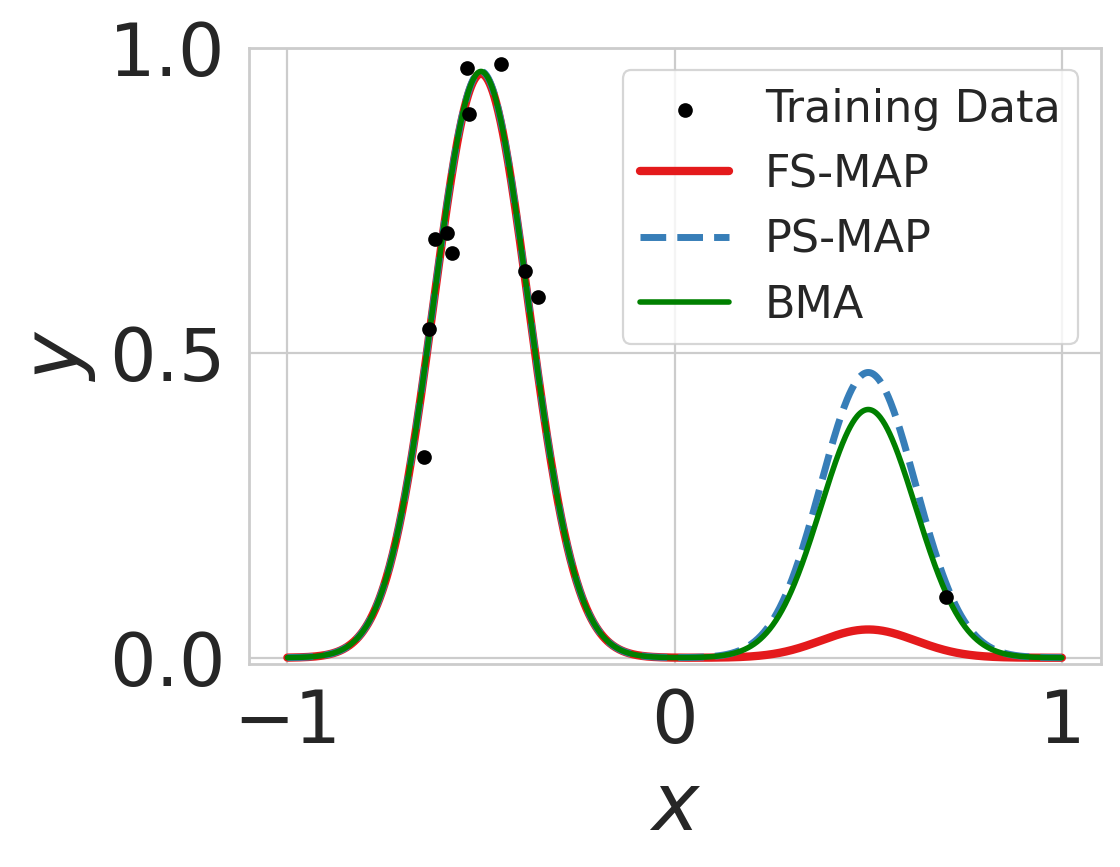

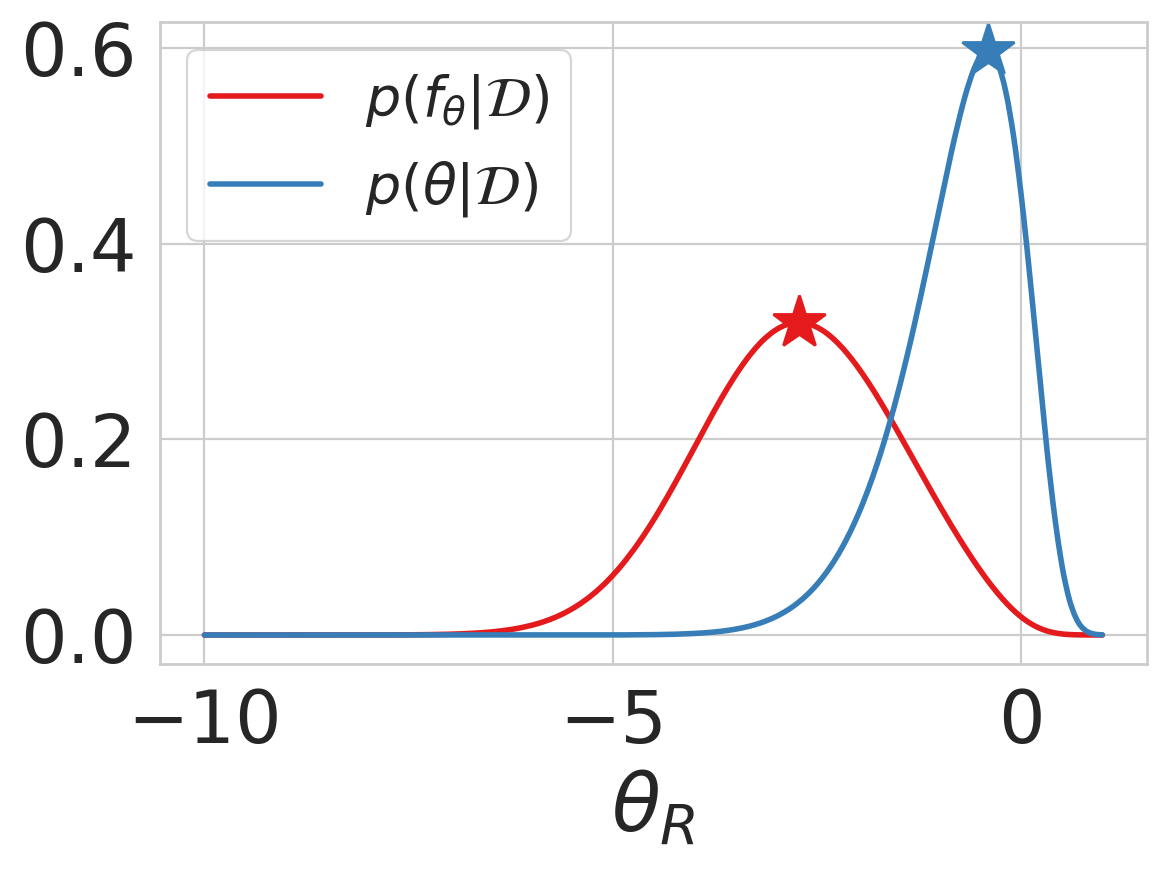

In [23]:
in_dim = 1
cs = [-0.5, 0.5]
width = 0.03
feature_fn = rbf_features(cs, width, height=1)

prior_scale = 1.2 # Change this to try other prior scales
prior_stds = prior_scale * np.ones(2)
act_fn = jnp.exp
model = NonLinearMixture(feature_fn, act_fn, prior_stds)

# optimizer
optimizer = 'adam'
lr = 3e-1
n_step = int(1000)


jitter = 1e-32
def x_eval_generator(rng_key):
    return jax.random.uniform(rng_key, shape=(1000, in_dim), minval=-1, maxval=1)

# ------------------------------ #
# output_dir = f'nonlinear_mixture/weights/{feature_name}'
os.makedirs('nonlinear_mixture/plots/', exist_ok=True)
skip_if_done = True

n_train = 10
x_train = jax.random.normal(jax.random.PRNGKey(0), shape=(n_train, in_dim)) * 0.2 - 0.5
y_train = jnp.exp(-(x_train + 0.5) ** 2 / 0.03).reshape(-1, 1)
# add noise
y_train += jax.random.normal(jax.random.PRNGKey(2), shape=y_train.shape) * 0.1
# add new data
new_x = jnp.array([0.7]).reshape(-1, in_dim)
new_y = jnp.array([0.1]).reshape(-1, 1)
x_train = jnp.concatenate([x_train, new_x], axis=0)
y_train = jnp.concatenate([y_train, new_y], axis=0)

noise_std = 0.1 # observation noise in likelihood
r = run_compare(model, in_dim, x_train, y_train, x_eval_generator, n_step, lr, optimizer, noise_std, jitter, temp=1, result_path=None, plot=True)
plt.savefig(f'nonlinear_mixture/plots/GM_{prior_scale}.pdf')

w2, pf, pw, w_ps, w_fs = r
pf = jax.nn.softmax(pf)
pw = jax.nn.softmax(pw)

# x = jnp.exp(w2) # not uniform spacing
x = w2
dx = jnp.diff(x)
dx = jnp.concatenate([dx, dx[-1:]]) # repeat the last element
pf_area = jnp.sum(pf * dx)
pw_area = jnp.sum(pw * dx)
# normalize area just for easy comparison
pf = pf / pf_area
pw = pw / pw_area
# Plot w2 and pf
plt.figure(figsize=(6.5, 5), dpi=200)
plt.plot(x, pf, label=r'$p(f_\theta|\mathcal{D})$', color='C0')
plt.plot(x, pw, label=r'$p(\theta|\mathcal{D})$', color='C1')
plt.xlabel(r'$\theta_R$')

# Label the max of each curve on the x-axis
pf_max_index = jnp.argmax(pf)
pw_max_index = jnp.argmax(pw)

plt.plot((w2[pf_max_index]), pf[pf_max_index], '*', color='C0', markersize=20)
plt.plot((w2[pw_max_index]), pw[pw_max_index], '*', color='C1', markersize=20)
# plt.yscale('log')
plt.legend(fontsize=20)
# add margin to each side
plt.tight_layout()

plt.savefig(f'nonlinear_mixture/plots/GM_posterior_{prior_scale}.pdf')
plt.show()
